# Improting necessary packages

In [1]:
import numpy as np
import glob
import os
import sys

import torch

from skimage import io
import cv2
from matplotlib import pyplot as plt

sys.path.append("../src")
import model
from util import inv_normalise_tensor
from transformations import colour_spaces

# Imputting the network with a latent representation of one vector

In [2]:
def compute_unique_hues(net, colour_space):
    primaries_rgb = []
    primaries_org = []
    primaries_lab = []
    primaries_hsv = []
    for i in range(net.state_dict()['emb.weight'].shape[1]):
        man_out = np.zeros((2, 2))
        man_out[:, :] = i
        net.f = 56
        top_sample = net.sample_inds(man_out)
        
        recon_sample = inv_normalise_tensor(top_sample, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        recon_sample = recon_sample.detach().numpy()
        recon_sample = recon_sample.squeeze().transpose(1,2,0)
        primaries_org.append(recon_sample.mean(axis=(0, 1)))
        if colour_space == 'dkl':
            recon_sample = colour_spaces.dkl012rgb(recon_sample)
            recon_sample = recon_sample.astype('float') / 255
        elif colour_space == 'lms':
            recon_sample = colour_spaces.lms012rgb(recon_sample)
            recon_sample = recon_sample.astype('float') / 255
        elif colour_space == 'lab':
            recon_sample = cv2.cvtColor((recon_sample*255).astype('uint8'), cv2.COLOR_LAB2RGB)
            recon_sample = recon_sample.astype('float') / 255
        primaries_rgb.append(recon_sample.mean(axis=(0, 1)))
        
        recon_sample_lab = cv2.cvtColor((recon_sample*255).astype('uint8'), cv2.COLOR_RGB2LAB)
        recon_sample_lab = recon_sample_lab.astype('float') / 255
        primaries_lab.append(recon_sample_lab.mean(axis=(0, 1)))
        recon_sample_hsv = cv2.cvtColor(recon_sample.astype('float32'), cv2.COLOR_RGB2HSV)
        recon_sample_hsv[:, :, 0] /= 360
        primaries_hsv.append(recon_sample_hsv.mean(axis=(0, 1)))
    return primaries_rgb, primaries_org, primaries_lab, primaries_hsv#

def plot_key(hues, key, figsize=(5, 2), rows=1):
    fig = plt.figure(figsize=figsize)
    for i, recon_sample in enumerate(hues[key]):
        ax = fig.add_subplot(rows, len(hues[key]) / rows, i+1)
        img = np.zeros((10, 10, 3))
        for j in range(3):
            img[1:-1, 1:-1, j] = recon_sample[j]
        ax.imshow(img)
        plt.axis('off')
    tcs = key.split('_')
    fig.suptitle("K=%d D=%d %s" % (int(tcs[0][1:]), int(tcs[1][1:]), tcs[2]))
    return fig

# Computing it for all our models

In [3]:
hues_rgb = dict()
hues_org = dict()
hues_lab = dict()
hues_hsv = dict()

models = [
    'k004_d128', 'k008_d008', 'k008_d128', 'k128_d128'
]
examined_colour_space = [
    'dkl2dkl', 'dkl2lab', 'dkl2rgb', 'dkl2lms',
    'lab2dkl', 'lab2lab', 'lab2rgb', 'lab2lms',
    'rgb2dkl', 'rgb2lab', 'rgb2rgb', 'rgb2lms',
    'lms2dkl', 'lms2lab', 'lms2rgb', 'lms2lms'
]
m_suffs = {
    'k004_d128': 'model_89.pth', 
    'k008_d008': 'model_89.pth', 
    'k008_d128': 'model_89.pth', 
    'k128_d128': 'model_39.pth',
}
m_ks = {
    'k004_d128': 4, 
    'k008_d008': 8, 
    'k008_d128': 8, 
    'k128_d128': 128,
}
m_ds = {
    'k004_d128': 128, 
    'k008_d008': 8, 
    'k008_d128': 128, 
    'k128_d128': 128,
}

for mname in models:
    for colour_space in examined_colour_space:
        model_path = '../models/%s/%s/%s' % (mname, colour_space, m_suffs[mname])
        out_key = mname + '_' + colour_space
        if os.path.exists(model_path):
            weights = torch.load(model_path, map_location='cpu')
            net = model.VQ_CVAE(128, k=m_ks[mname], kl=m_ds[mname])
            net.load_state_dict(weights)
            net.eval()
            (
                hues_rgb[out_key], hues_org[out_key], hues_lab[out_key], hues_hsv[out_key]
            ) = compute_unique_hues(net, colour_space[4:])

# Plotting for K=4 and D=128

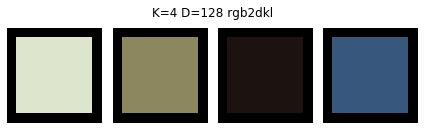

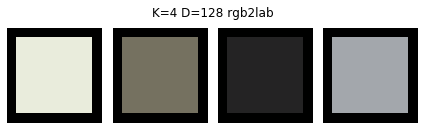

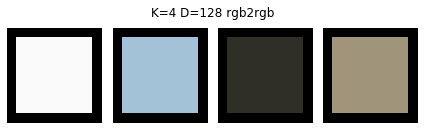

In [4]:
for mname in hues_rgb.keys():
    if 'k004' in mname:
        figsize = (6, 2)
        current_fig = plot_key(hues_rgb, mname, figsize=figsize)
        current_fig.tight_layout()

# Plotting for K=8 and D=128

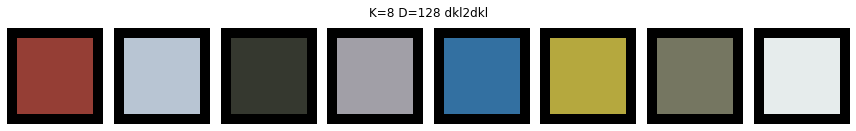

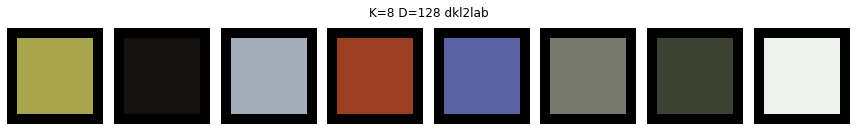

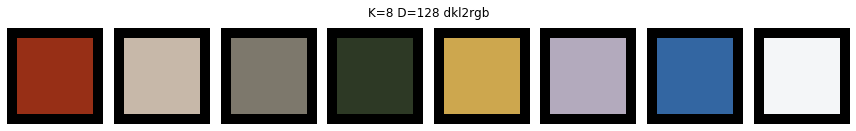

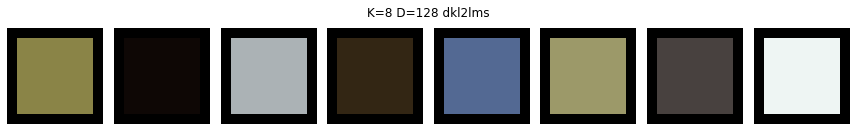

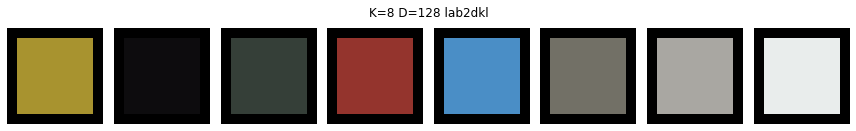

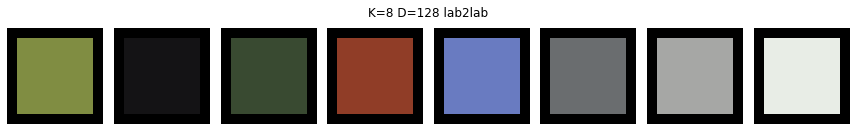

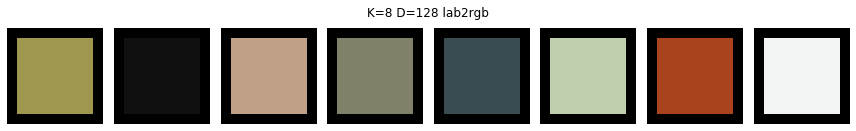

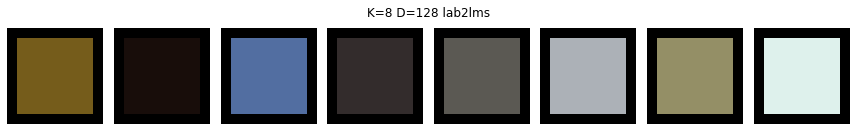

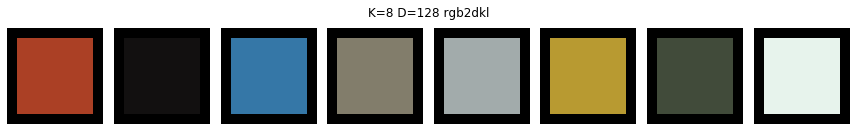

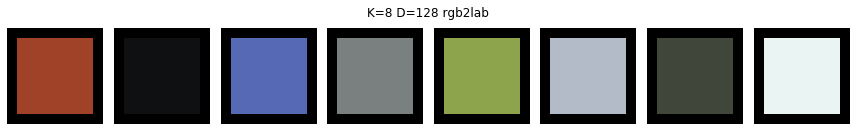

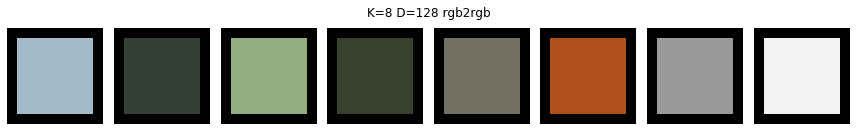

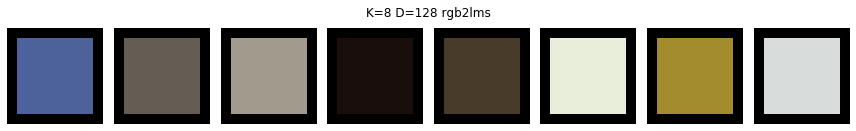

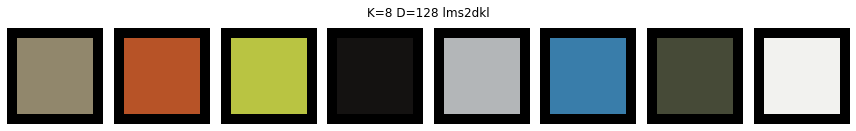

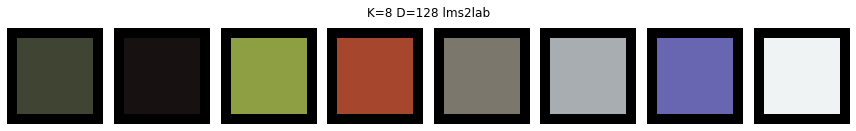

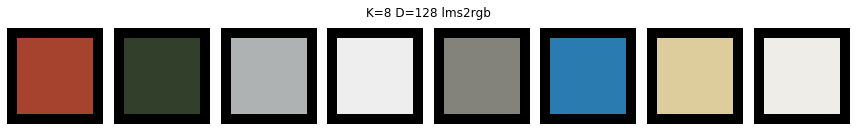

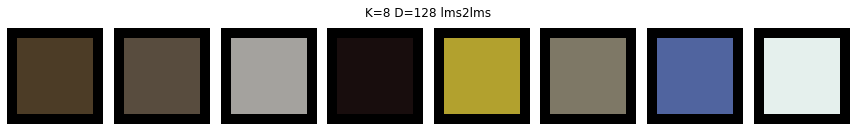

In [5]:
for mname in hues_rgb.keys():
    if 'k008_d128' in mname:
        figsize = (12, 2)
        current_fig = plot_key(hues_rgb, mname, figsize=figsize)
        current_fig.tight_layout()

# Plotting for K=8 and D=8

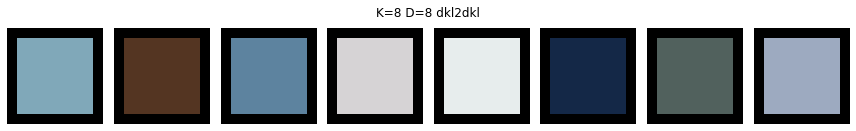

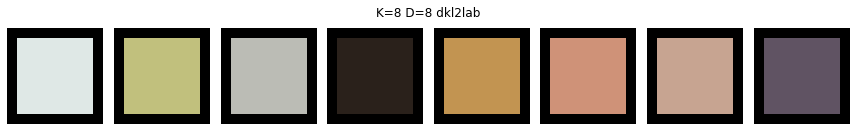

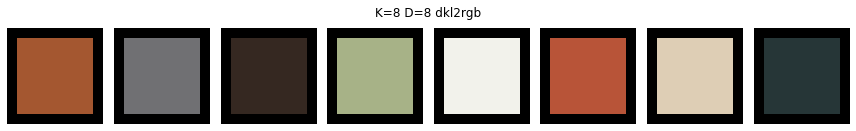

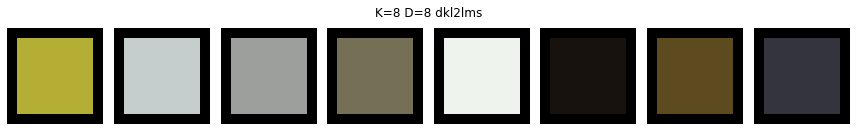

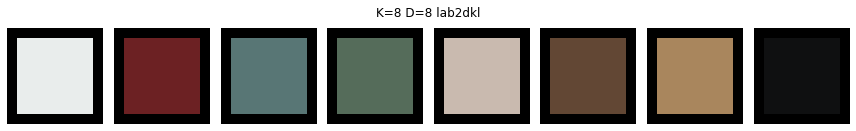

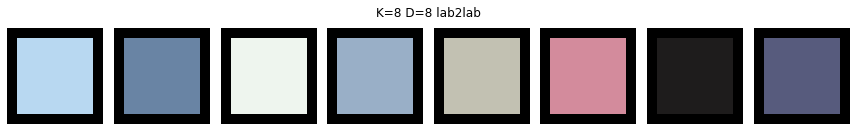

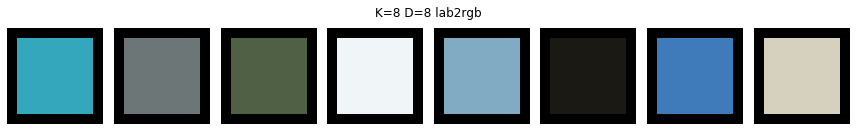

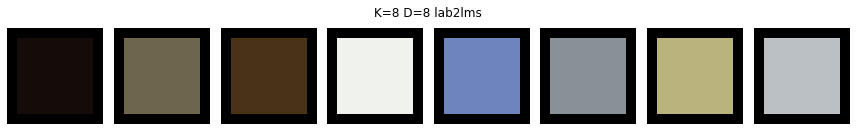

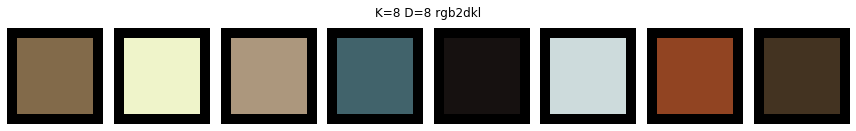

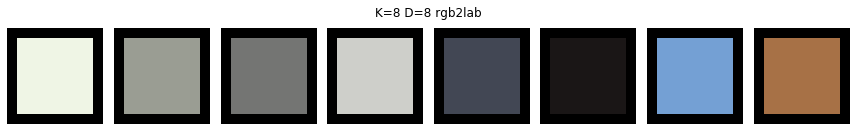

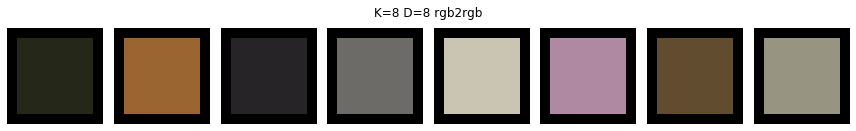

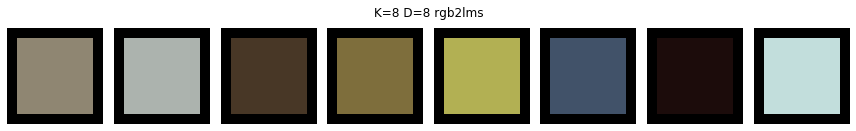

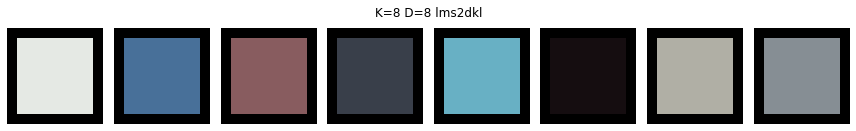

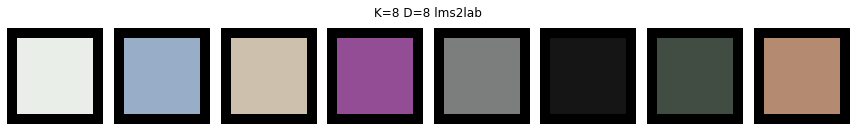

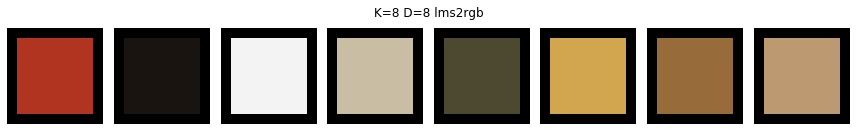

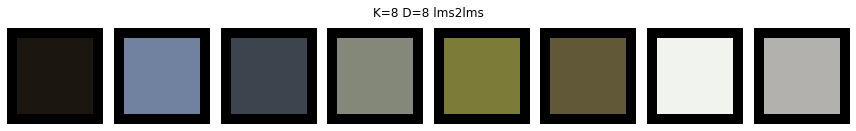

In [6]:
for mname in hues_rgb.keys():
    if 'k008_d008' in mname:
        figsize = (12, 2)
        current_fig = plot_key(hues_rgb, mname, figsize=figsize)
        current_fig.tight_layout()

# Plotting for K=128 and D=128

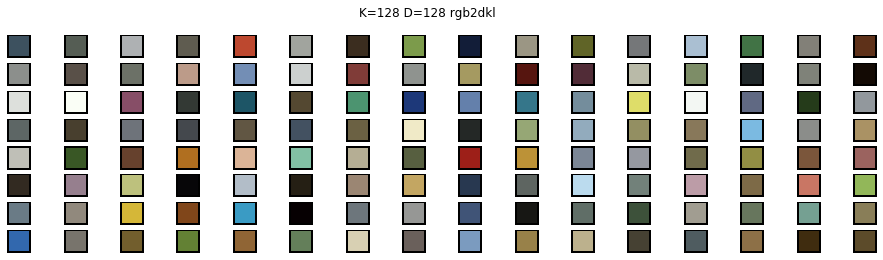

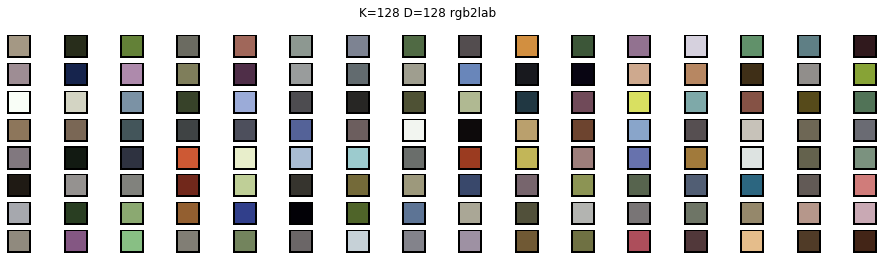

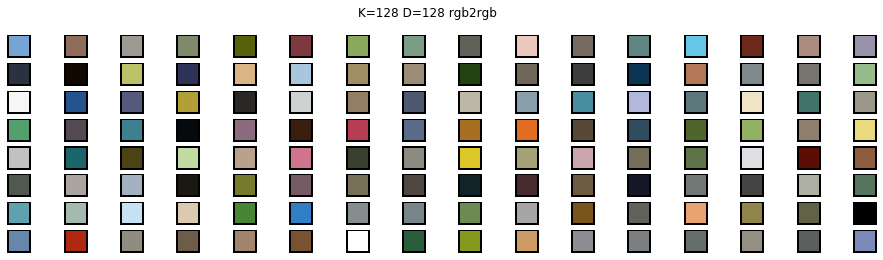

In [7]:
for mname in hues_rgb.keys():
    if 'k128_d128' in mname:
        figsize = (16, 4)
        current_fig = plot_key(hues_rgb, mname, figsize=figsize, rows=8)